In [1]:
import os
import re
import math
import numpy as np
import random
from collections import defaultdict

import matplotlib
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = False

import seaborn as sns
sns.set(font_scale = 1.8)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['xtick.labelsize'] = 18
# matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.xmargin'] = 0.1
matplotlib.rcParams['axes.ymargin'] = 0.1
matplotlib.rc('font', **{'weight': 'normal', 'size': 28})
# plt.style.use('dark_background')

In [2]:
def get_best(search_key, all_logs, time_horizon):
    
    relevant_logs = []
    for log in all_logs:
        if re.search(search_key, log): 
            f = open(log, "r") ; lines = f.readlines() ; f.close()
            relevant_logs.append([ log, lines ])
            
    VAL_METRIC = "RMSE_mean"
    # VAL_METRIC = "RMSE_{}".format(time_horizon) # "RMSE_mean" ???
    
    NEEDED_METRICS = { "RMSE_{}".format(t) for t in range(1, time_horizon + 1) }

    final = [ { VAL_METRIC: float(1e6) } ] 
    for log_name, lines in relevant_logs:

        best, all_metrics = float(1e6), {}
        for line in lines:
            line = line.strip()
            
            if line.endswith("(TEST)"):
                this_metrics = {}
                for m in line[:-7].split(" | "): # removing " (TEST)"
                    if "=" not in m: continue
                    key, val = m.split(" = ")
                    if key in [ 'time', 'Rand P@1', 'Rand MRR', 'CPU_RAM', 'GPU' ]: continue
                    
                    this_metrics[key] = float(val)
                
                if VAL_METRIC not in this_metrics: continue
                if any(map(lambda x: x not in this_metrics, NEEDED_METRICS)): continue

                if this_metrics[VAL_METRIC] < best:
                    best, all_metrics = float(this_metrics[VAL_METRIC]), this_metrics

        if len(all_metrics) > 0: final.append(all_metrics)

    return list(sorted(final, key = lambda x: float(x[VAL_METRIC])))[:10]

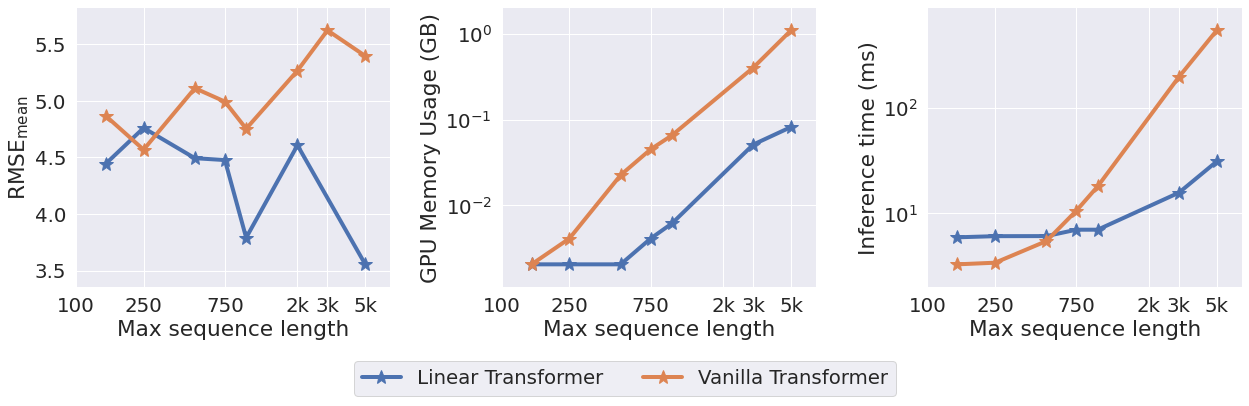

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

seq_len_vals = [ 100, 150, 250, 500, 750, 1_000, 1_500, 2_000, 3_000, 5_000 ]
# if DATASET == "toyota":
#     seq_len_vals = [ 500, 1_000, 3_000 ]
# if DATASET == "openacc":
#     seq_len_vals = [ 1_000, 2_000, 5_000 ]

gpu_usage = {
    "openacc": {
        "Linear Transformer": {
            150: [ 2.1, 0.00593 ],
            250: [ 2.1, 0.00608 ],
            500: [ 2.1, 0.00609 ],
            750: [ 4.2, 0.007 ],
            1000: [ 6.3, 0.007 ],
            3000: [ 52.4, 0.0157 ],
            5000: [ 83.9, 0.031 ]
        },
        
        "Vanilla Transformer": {
            150: [ 2.1, 0.00329 ],
            250: [ 4.2, 0.00341 ],
            500: [ 23.1, 0.00546 ],
            750: [ 46.1, 0.0106 ],
            1000: [ 67.1, 0.018 ],
            3000: [ 413.1, 0.1959 ],
            5000: [ 1.1 * 1024, 0.54 ]
        }
    }
}

for at_d, DATASET in enumerate([ 
    "openacc" 
]):
    all_logs = {}

    BASE_PATH = "../results/{}/logs/".format(DATASET)
    all_logs["Linear Transformer"] = os.listdir(BASE_PATH)
    all_logs["Linear Transformer"] = list(map(lambda x: BASE_PATH + x, all_logs["Linear Transformer"]))

    BASE_PATH = "../results/{}/logs_attention_bug/".format(DATASET)
    all_logs["Vanilla Transformer"] = os.listdir(BASE_PATH)
    all_logs["Vanilla Transformer"] = list(map(lambda x: BASE_PATH + x, all_logs["Vanilla Transformer"]))
    BASE_PATH = "../results/{}_old/logs/".format(DATASET)
    temp = os.listdir(BASE_PATH)
    temp = list(map(lambda x: BASE_PATH + x, temp))
    all_logs["Vanilla Transformer"] += temp

    for at_m, m in enumerate([
        'Linear Transformer',
        'Vanilla Transformer',
    ]):

        for at_v, metric in enumerate([ "RMSE_mean" ]):

            vals = defaultdict(list)

            for v in seq_len_vals:

                if m == "Vanilla Transformer":
                    search = ".*SASRec_latent.*_max_seq_len_{}_bsz.*".format(v)
                elif m == "Linear Transformer":
                    search = ".*SASRec_latent.*_max_seq_len_{}_transformer_len.*".format(v)

                top_50 = get_best(search, all_logs[m], 100)

                for result in top_50:
                    if metric not in result: continue
                    if result[metric] > float(1e2): continue
                    vals[v].append(result[metric])

            p = ax[at_d]
            
            mapping = {
                "Vanilla Transformer": "Vanilla Transformer",
                "Linear Transformer": "Linear Transformer"
            }
            
            p.plot(vals.keys(), [ np.min(vals[i]) for i in vals ], '-*', label = mapping[m] if at_d == 0 else None)
            p.set_xscale("log")
        
            ticks = [ 100, 250, 750, 2000, 3000, 5000 ] # seq_len_vals[::2]
            if seq_len_vals[-1] != ticks[-1]: ticks.append(seq_len_vals[-1])
            p.set_xticks(ticks)
            p.set_xticklabels([ i if i < 1000 else str(round(i / 1000.0)) + "k" for i in ticks ])
            # p.set_title(DATASET)
            p.set_xlabel("Max sequence length")
            p.set_ylabel(r"$\mathrm{RMSE}_{\mathrm{mean}}$")
            
        stats = gpu_usage[DATASET][m]
        
        p = ax[1]
        p.plot(stats.keys(), [ stats[i][0] / 1024.0 for i in stats ], '-*')
        p.set_xscale("log")
        p.set_yscale("log")
        p.set_xticks(ticks)
        p.set_xticklabels([ i if i < 1000 else str(round(i / 1000.0)) + "k" for i in ticks ])
        p.set_xlabel("Max sequence length")
        p.set_ylabel(r"GPU Memory Usage (GB)")
        
        p = ax[2]
        p.plot(stats.keys(), [ stats[i][1] * 1000.0 for i in stats ], '-*')
        p.set_xscale("log")
        p.set_yscale("log")
        p.set_xticks(ticks)
        p.set_xticklabels([ i if i < 1000 else str(round(i / 1000.0)) + "k" for i in ticks ])
        p.set_xlabel("Max sequence length")
        p.set_ylabel(r"Inference time (ms)")

# fig.suptitle("Open-ACC")
fig.tight_layout()
plt.subplots_adjust(bottom = 0.28)
fig.legend(loc = 8, ncol = 2)
fig.show()
fig.savefig("linear_transformer_inference.pdf")